In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm


def make_animation(sim, total_frames, steps_per_frame=1, interval=100):
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML

    def update(frame_number):
        for _ in range(steps_per_frame):
	        sim.step()
        return sim.draw()

    sim.initialize()
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output

In [108]:
class Simulation:
    '''
    Compute the Simulation of
    '''

    def __init__(self, nodes, edges, prob_infect, prob_recover, prob_sever):
        '''
        Set simulation parameters.
        '''
        self.nodes = nodes
        self.edges = edges
        self.prob_infect = prob_infect
        self.prob_recover = prob_recover
        self.prob_sever = prob_sever

        self.layout_rings = 10  # Number of concentric rings in the shell plot

    def initialize(self):
        '''
        Initialize node states and clear out the simulation history.
        '''
        for i in self.graph.nodes:
            self.graph.nodes[i]['state'] = int(np.random.uniform(0, 1) < 0.1) #only 10% of the nodes are initialized infected
        self.history = []
        # Create a new figure for use in the draw() method below
        self.figure, self.axes = plt.subplots(1, 2, figsize=(10, 5))

    def set_barabasi_albert(self):
        '''
        Set up the simulation to run on a Barabasi-Albert random graph.
        '''
        self.graph = nx.barabasi_albert_graph(self.nodes, self.edges // 2)
        self.network_name = 'Barabasi-Albert'

    def set_watts_strogatz(self):
        '''
        Set up the simulation to run on a Watts-Strogatz random graph.
        '''
        self.graph = nx.watts_strogatz_graph(self.nodes, self.edges, 1)
        self.network_name = 'Watts-Strogatz'

    def set_erdos_renyi(self):
        '''
        Set up the simulation to run on a Erdos-Renyi random graph.
        '''
        self.graph = nx.erdos_renyi_graph(self.nodes,
                                          self.edges / (self.nodes - 1))
        self.network_name = 'Erdos-Renyi'

    def draw(self):
        '''
        Plot the network state, degree distribution, and infection history.
        '''
        plots = []

        self.axes[0].clear()
        plots.append(self.axes[0].plot(self.history))

        average_infection = round(sum(self.history) / len(self.history),2)

        # Plot average line
        self.axes[0].axhline(average_infection, color='r', linestyle='--', label=f'Mean = {average_infection}')

        self.axes[0].set_xlabel('Step')
        self.axes[0].set_ylabel('Proportion infected (%)')
        self.axes[0].set_xlim(0, 1000)
        self.axes[0].set_ylim(0, max(self.history) * 1.05 if len(self.history) > 0 else 1)
        self.axes[0].set_title('Step: ' + str(len(self.history)))
        self.axes[0].legend()
        self.axes[0].set_title(f'Infected Percentage in {self.network_name} model with \n$p_i = {self.prob_infect}$, $p_r = {self.prob_recover}$, $p_s = {self.prob_sever}$')

        degrees = dict(self.graph.degree())
        degree_values = list(degrees.values())
        average_degree = round(np.mean(degree_values),2)

        self.axes[1].clear()
        self.axes[1].hist(degree_values, bins=20, density=True, alpha=0.75)
        self.axes[1].axvline(average_degree, color='r', linestyle='--', label=f'Mean = {average_degree}')
        self.axes[1].set_xlabel('Degree')
        self.axes[1].set_ylabel('Degree probabulity (%)')
        self.axes[1].legend()
        self.axes[1].set_title(f'Degree distribution for {self.network_name} model with \n$p_i = {self.prob_infect}$, $p_r = {self.prob_recover}$, $p_s = {self.prob_sever}$')
        plt.show()
        return tuple(plots)

    def step(self):
        '''
        Update the network state.
        '''
        new_state = {}
        # add edges to be removed
        edges_to_remove = []
        for a in self.graph.nodes:
            if self.graph.nodes[a]['state'] == 0:  # If node is susceptible
                new_state[a] = 0

                if self.graph.degree(a) > 0:
                    # Check if neighbors are infected

                # while self.graph.degree(a) > 0:
                    for b in self.graph.neighbors(a):

                        if self.graph.nodes[b]['state'] == 1:

                            # check for b self-quarantine
                            if np.random.uniform(0, 1) < self.prob_sever:
                                # add the edges to remove
                                edges_to_remove.append((a, b))

                            else:
                                new_state[a] = 1 if np.random.uniform(0, 1) < self.prob_infect else 0

                            if new_state[a] == 1:
                                # Just got infected, so we can stop checking
                                break

            else: # If node is infected
                new_state[a] = 0 if np.random.uniform(0, 1) < self.prob_recover else 1

        # remove edges
        for edge in edges_to_remove:
            self.graph.remove_edge(*edge)

        for i in self.graph.nodes:
            self.graph.nodes[i]['state'] = new_state[i]
        self.history.append(sum(new_state.values()) / len(new_state))

In [ ]:
nodes = 1000
avr_degree = 10
inf_prob = 0.01
rec_prob = 0.05
sever_prob = 0.02

sim = Simulation(nodes, avr_degree, inf_prob, rec_prob, sever_prob)

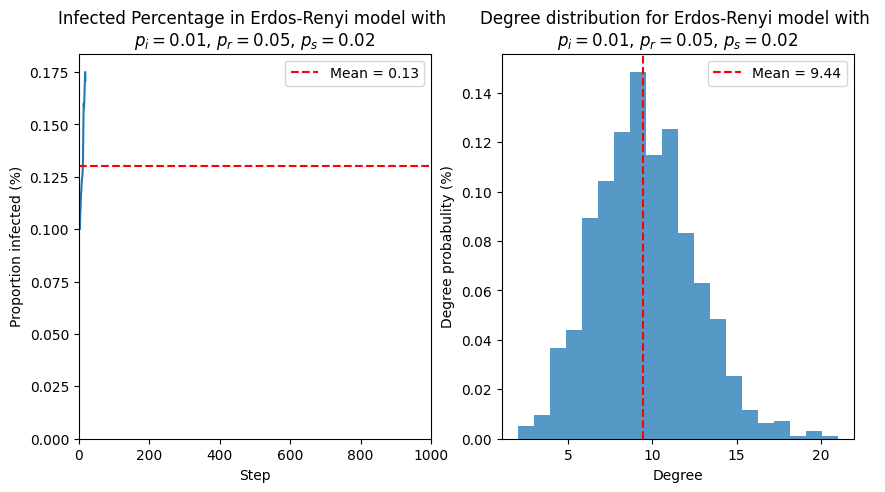

In [ ]:
sim.set_erdos_renyi()
make_animation(sim, total_frames=50, steps_per_frame=20, interval=250)

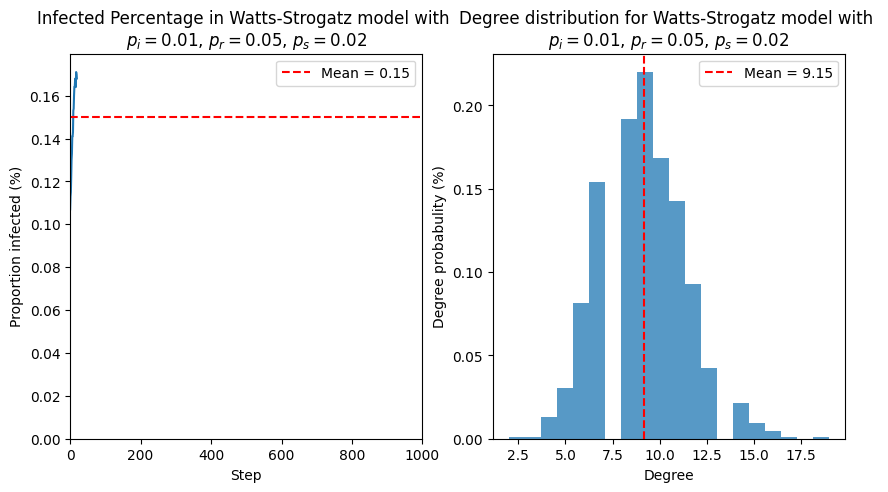

In [ ]:
sim.set_watts_strogatz()
make_animation(sim, total_frames=50, steps_per_frame=20, interval=250)

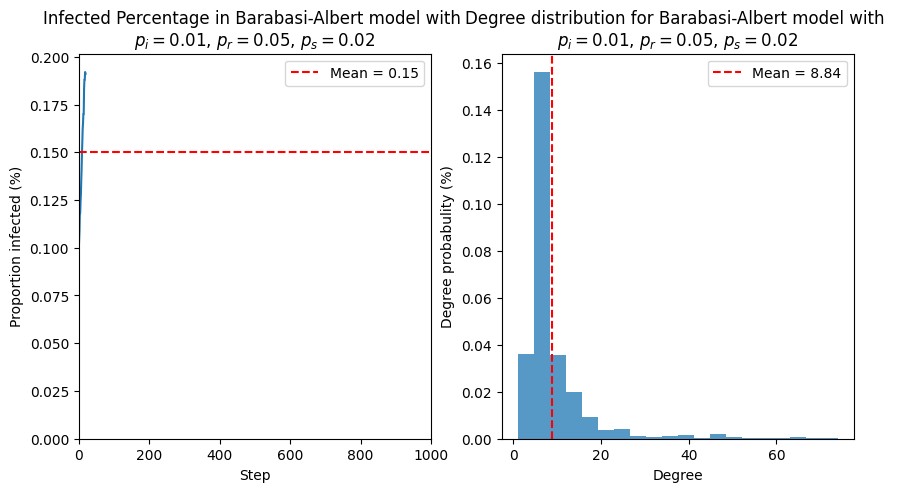

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x500', '-pix_fmt', 'rgba', '-r', '4.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp656ddmel/temp.m4v']' returned non-zero exit status 255.

In [ ]:
sim.set_barabasi_albert()
make_animation(sim, total_frames=50, steps_per_frame=20, interval=250)

In [ ]:
print('Ratio pr/pi =', round(rec_prob/inf_prob, 2))

Ratio pr/pi = 5.0


In [ ]:
import tqdm as tqdm
nodes = 1000
avr_degree = 10
inf_prob = 0.01
rec_prob = 0.05

ps_values = np.linspace(1e-1, 1e-10, 50)

trials = 1000
average_degrees = []

for ps in tqdm(ps_values):
    sim = Simulation(nodes, avr_degree, inf_prob, rec_prob, ps)
    sim.set_erdos_renyi()
    sim.initialize()
    for _ in tqdm(range(trials)):
        sim.step()

    degrees = dict(sim.graph.degree())
    degree_values = list(degrees.values())
    average_degrees.append(round(np.mean(degree_values), 2))

plt.figure()
plt.semilogx(ps_values, average_degrees)
plt.axhline(round(rec_prob/inf_prob, 2), linestyle='--', color='r', label='ratio pr/pi')
plt.xlabel('Probability of Quarantine (p_s)')
plt.ylabel('Average Degree')
plt.title(f'Effect of Quarantine Probability on Average Degree for {sim.network_name}')
plt.legend()
plt.show()

 40%|████      | 20/50 [01:55<02:47,  5.58s/it]<ipython-input-105-715fa250bdcf>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.figure, self.axes = plt.subplots(1, 2, figsize=(10, 5))

  2%|▏         | 22/1000 [00:00<00:21, 46.41it/s]

In [ ]:
# Watts-Strogatz
average_degrees = []

for ps in tqdm(ps_values):
    sim = Simulation(nodes, avr_degree, inf_prob, rec_prob, ps)
    sim.set_watts_strogatz()
    sim.initialize()
    for _ in tqdm(range(trials)):
        sim.step()

    degrees = dict(sim.graph.degree())
    degree_values = list(degrees.values())
    average_degrees.append(round(np.mean(degree_values), 2))

plt.figure()
plt.plot(ps_values, average_degrees, color='k', linestyle='--', marker='o')
plt.axhline(round(rec_prob/inf_prob, 2), linestyle='--', color='r', label='ratio pr/pi')
plt.xlabel('Probability of Quarantine (p_s)')
plt.ylabel('Average Degree')
plt.title(f'Effect of Quarantine Probability on Average Degree for {sim.network_name}')
plt.legend()
plt.show()

plt.figure()
plt.semilogx(ps_values, average_degrees, color='k', linestyle='--', marker='o')
plt.axhline(round(rec_prob/inf_prob, 2), linestyle='--', color='r', label='ratio pr/pi')
plt.xlabel('Probability of Quarantine (p_s)')
plt.ylabel('Average Degree')
plt.title(f'Effect of Quarantine Probability on Average Degree for {sim.network_name}')
plt.legend()
plt.show()


In [ ]:
# Barabasi-Albert
average_degrees = []

for ps in tqdm(ps_values):
    sim = Simulation(nodes, avr_degree, inf_prob, rec_prob, ps)
    sim.set_barabasi_albert()
    sim.initialize()
    for _ in tqdm(range(trials)):
        sim.step()

    degrees = dict(sim.graph.degree())
    degree_values = list(degrees.values())
    average_degrees.append(round(np.mean(degree_values), 2))

plt.figure()
plt.plot(ps_values, average_degrees, color='k', linestyle='--', marker='o')
plt.axhline(round(rec_prob/inf_prob, 2), linestyle='--', color='r', label='ratio pr/pi')
plt.xlabel('Probability of Quarantine (p_s)')
plt.ylabel('Average Degree')
plt.title(f'Effect of Quarantine Probability on Average Degree for {sim.network_name}')
plt.legend()
plt.show()

plt.figure()
plt.semilogx(ps_values, average_degrees, color='k', linestyle='--', marker='o')
plt.axhline(round(rec_prob/inf_prob, 2), linestyle='--', color='r', label='ratio pr/pi')
plt.xlabel('Probability of Quarantine (p_s)')
plt.ylabel('Average Degree')
plt.title(f'Effect of Quarantine Probability on Average Degree for {sim.network_name}')
plt.legend()
plt.show()
